<a href="https://colab.research.google.com/github/abdelfatah2000/Graduation-Project/blob/main/Power_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#How PV works?

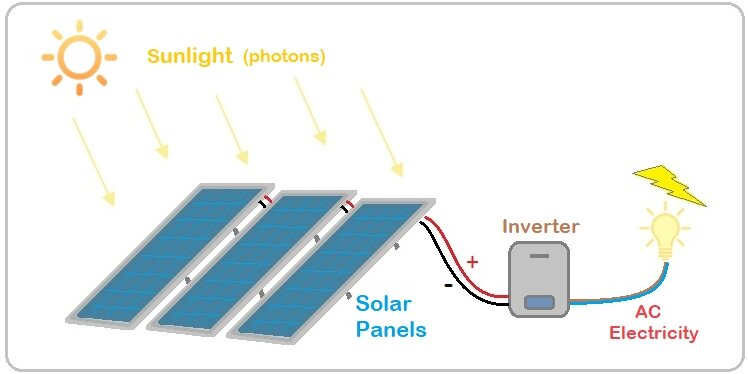

**When a photon hits the surface of the photovoltaic cell some of them panel absorb them and another reflect, absorbed photons energy are transferred to the electrons present on the silicon cell. These electrons are "excited" and begin to flow in the circuit producing electric current. A solar panel produces Direct Current energy,(DC power).
Then, it's up to the inverter to convert it into alternating current to transport it and use it in our distribution networks. In fact, domestic and industrial buildings are designed for the transport and use of alternating current.**

###So they are many factors affects the power come from solar panel:


*   Temperature.
*   Inverter Efficiency.



#Data

##We have two files: 


1.   Generation Data



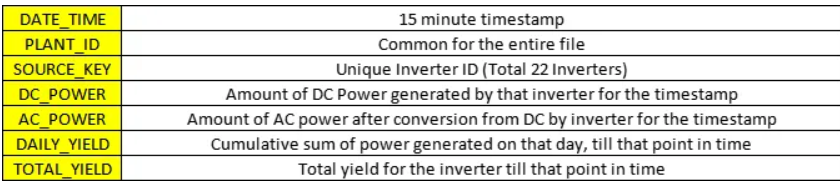






2.   Sensor Data


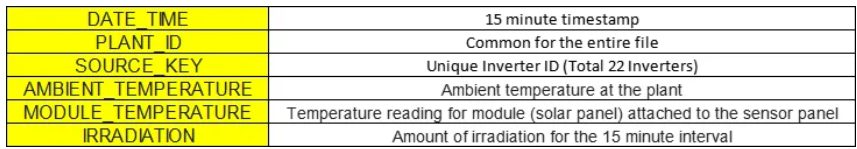

#Importing Packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
gen_data = pd.read_csv('/content/Plant_2_Generation_Data.csv')
weather_data = pd.read_csv('/content/Plant_2_Weather_Sensor_Data.csv')
gen_data['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
weather_data['DATE_TIME']= pd.to_datetime(weather_data['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

In [ ]:
gen_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,2020-05-15,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,2020-05-15,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,2020-05-15,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,2020-05-15,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07


In [ ]:
weather_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


#EDA

In [ ]:
gen_data.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,67698.0,67698.000000,67698.000000,67698.000000,6.769800e+04
mean,4136001.0,246.701961,241.277825,3294.890295,6.589448e+08
std,0.0,370.569597,362.112118,2919.448386,7.296678e+08
min,4136001.0,0.000000,0.000000,0.000000,0.000000e+00
25%,4136001.0,0.000000,0.000000,272.750000,1.996494e+07
50%,4136001.0,0.000000,0.000000,2911.000000,2.826276e+08
75%,4136001.0,446.591667,438.215000,5534.000000,1.348495e+09
max,4136001.0,1420.933333,1385.420000,9873.000000,2.247916e+09


In [ ]:
for column in gen_data.columns:
    print(f"{column}: Number of unique values {gen_data[column].nunique()}")
    print("==========================================================")

DATE_TIME: Number of unique values 3259
PLANT_ID: Number of unique values 1
SOURCE_KEY: Number of unique values 22
DC_POWER: Number of unique values 30825
AC_POWER: Number of unique values 30783
DAILY_YIELD: Number of unique values 30490
TOTAL_YIELD: Number of unique values 33115


We can see that there is a gap between AC_POWER and DC_POWER that is return to efficiency of the inverter.

In [ ]:
for column in weather_data.columns:
    print(f"{column}: Number of unique values {weather_data[column].nunique()}")
    print("==========================================================")

DATE_TIME: Number of unique values 3259
PLANT_ID: Number of unique values 1
SOURCE_KEY: Number of unique values 1
AMBIENT_TEMPERATURE: Number of unique values 3259
MODULE_TEMPERATURE: Number of unique values 3259
IRRADIATION: Number of unique values 1863


In [ ]:
eff_data = gen_data.copy()
eff_data['efficiency'] = eff_data['AC_POWER']/eff_data['DC_POWER']
eff_data['efficiency'].mean(axis=0)

0.9768063442756191

As we can see below PLANT_1 it's able to convert about only 9-10 % of DC POWER produced by module: Inverters are inefficient

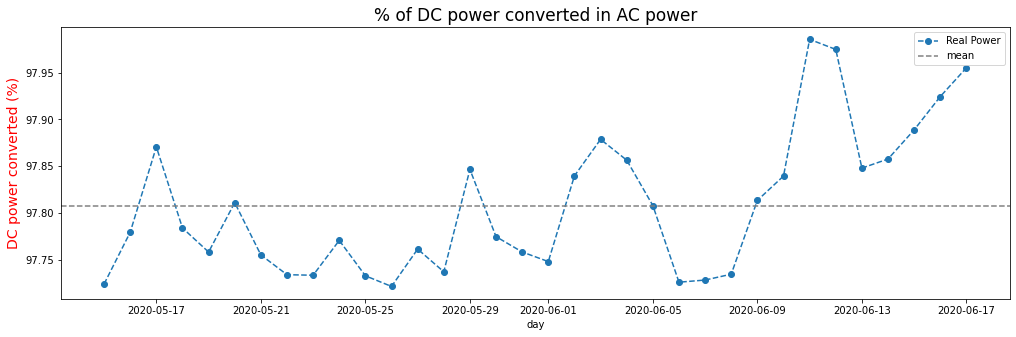

In [ ]:
losses=gen_data.copy()
losses['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'],format='%d-%m-%Y %H:%M')
losses['day']=losses['DATE_TIME'].dt.date
losses=losses.groupby('day').sum()
losses['losses']=losses['AC_POWER']/losses['DC_POWER']*100

losses['losses'].plot(style='o--',figsize=(17,5),label='Real Power')

plt.title('% of DC power converted in AC power',size=17)
plt.ylabel('DC power converted (%)',fontsize=14,color='red')
plt.axhline(losses['losses'].mean(),linestyle='--',color='gray',label='mean')
plt.legend()
plt.show()

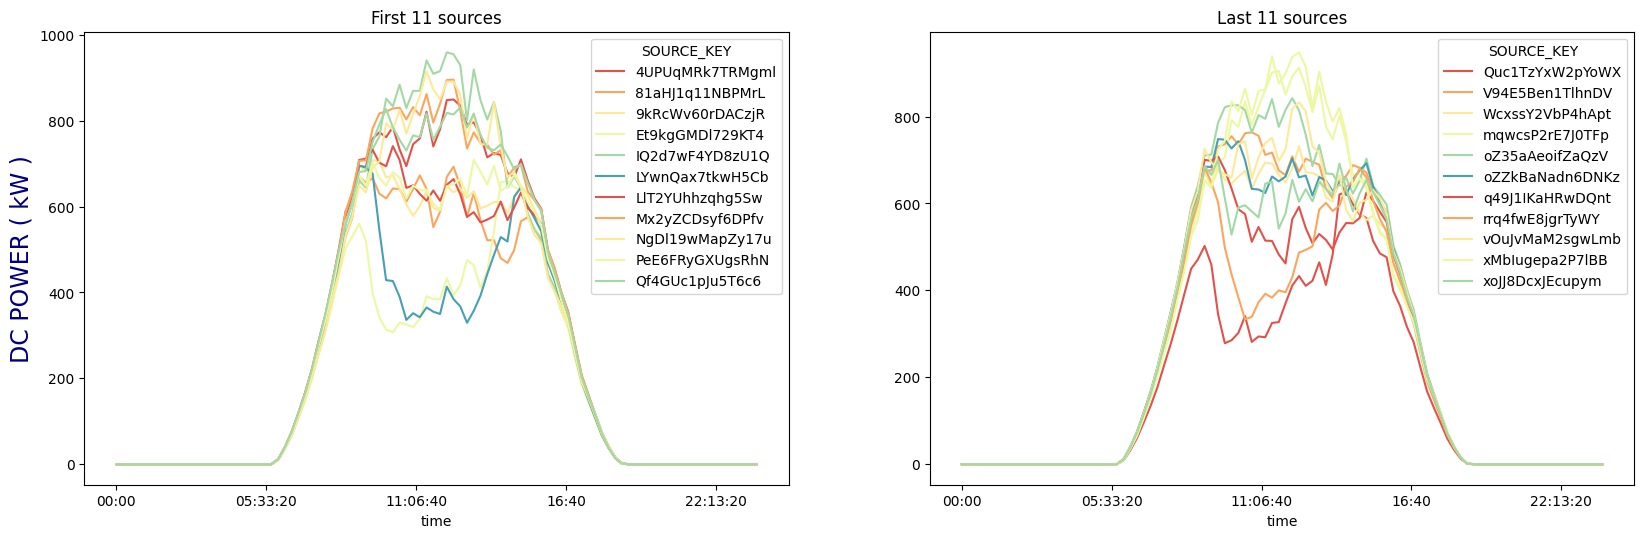

In [ ]:
dc_gen=gen_data.copy()
dc_gen['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'],format='%d-%m-%Y %H:%M')
dc_gen['time']=dc_gen['DATE_TIME'].dt.time
dc_gen=dc_gen.groupby(['time','SOURCE_KEY'])['DC_POWER'].mean().unstack()

cmap = sns.color_palette("Spectral", n_colors=6)

fig,ax=plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,6))
dc_gen.iloc[:,0:11].plot(ax=ax[0],color=cmap)
dc_gen.iloc[:,11:22].plot(ax=ax[1],color=cmap)

ax[0].set_title('First 11 sources')
ax[0].set_ylabel('DC POWER ( kW )',fontsize=17,color='navy')
ax[1].set_title('Last 11 sources')
plt.show()

Here we can see, clearly, that 1BY6WEcLGh8j5v7 & bvBOhCH3iADSZry are underperforming compared to other inverters, maybe these inverters require maintenance or require to be replaced. But before going into deep with underperforming inverters, let's look at which are the common problems for the entire plant,so let's see DC power generation during day hours for all 34 days

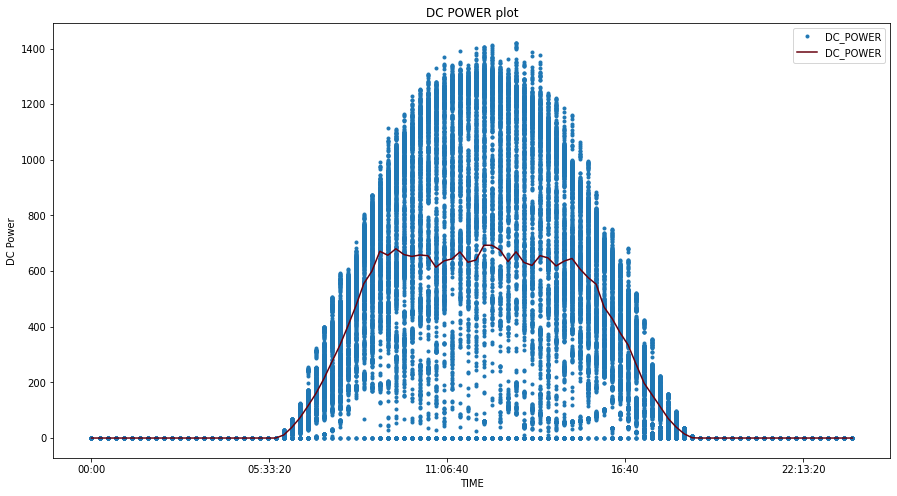

In [ ]:
data = gen_data.copy()
data['DATE_TIME'] = pd.to_datetime(data['DATE_TIME'], errors='coerce')
data['TIME'] = data['DATE_TIME'].dt.time
data.plot(x= 'TIME', y='DC_POWER', style='.', figsize = (15, 8))
data.groupby('TIME')['DC_POWER'].agg('mean').plot(legend=True, colormap='Reds_r')
plt.ylabel('DC Power')
plt.title('DC POWER plot')
plt.show()

Between 05:33:20 and 18:00:00, the Plant produces a dc power but otherwise there is null. The reason is sunlight.

In [ ]:
power_sensor = weather_data.merge(gen_data, left_on='DATE_TIME', right_on='DATE_TIME')

In [ ]:
power_sensor.drop(columns=['DAILY_YIELD', 'TOTAL_YIELD', 'PLANT_ID_y', 'PLANT_ID_x', 'SOURCE_KEY_x', 'SOURCE_KEY_y'], axis=1, inplace=True)

In [ ]:
power_sensor.head()

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER
0,2020-05-15,27.004764,25.060789,0.0,0.0,0.0
1,2020-05-15,27.004764,25.060789,0.0,0.0,0.0
2,2020-05-15,27.004764,25.060789,0.0,0.0,0.0
3,2020-05-15,27.004764,25.060789,0.0,0.0,0.0
4,2020-05-15,27.004764,25.060789,0.0,0.0,0.0


#Correlation

In [ ]:
corr = power_sensor.corr(method = 'spearman')

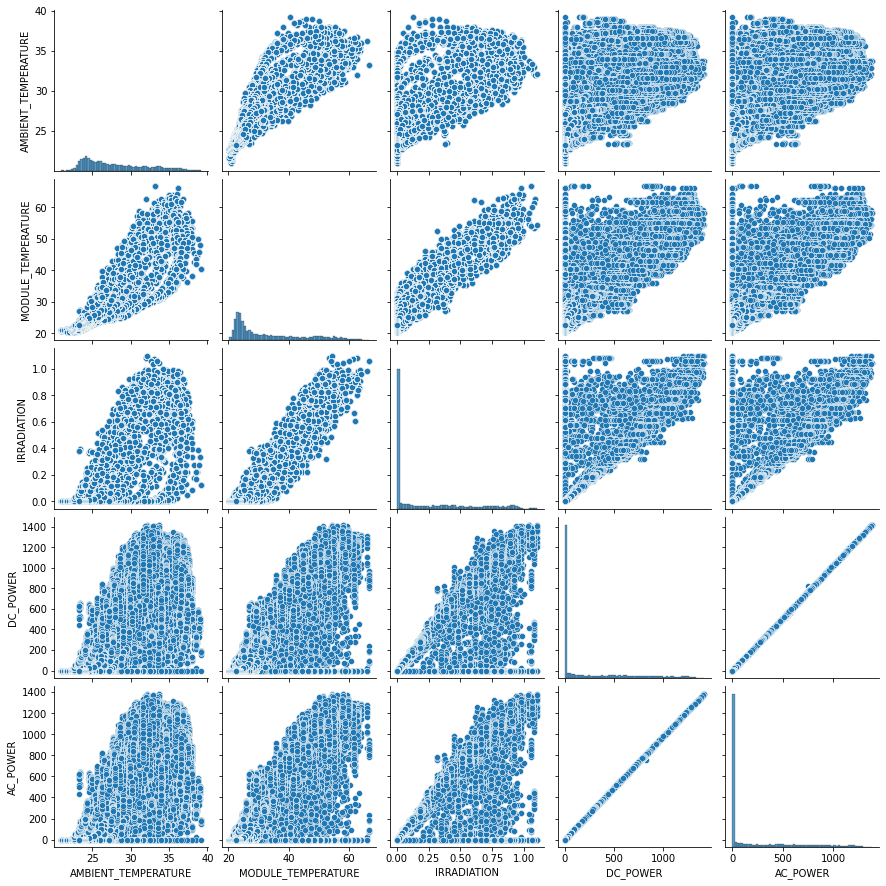

In [ ]:
sns.pairplot(power_sensor)
plt.show()

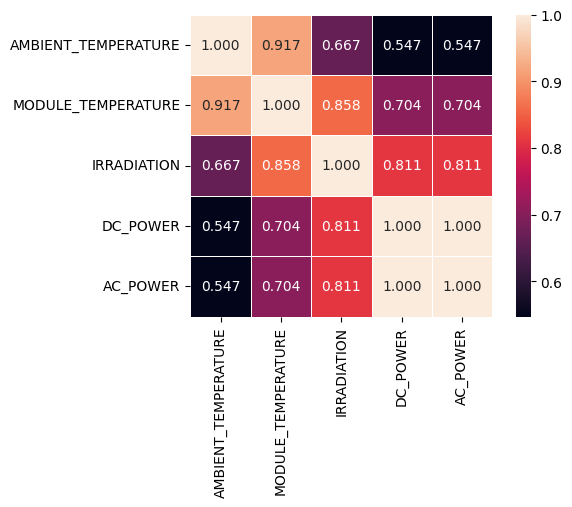

In [ ]:
plt.figure(dpi=100)
sns.heatmap(corr, robust=True, annot=True, fmt='0.3f', linewidths=.5, square=True)
plt.show()

Strong linear relation between AC Power & Irradiation and Module Temperature & Irradiation.

#Feature Engineering

PLANT_ID and SOURCE_KEY is constant.

In [ ]:
gen_data.drop('PLANT_ID', axis=1, inplace=True)
weather_data.drop('PLANT_ID', axis=1, inplace=True)

SOURCE_KEY is a unique Inverter ID so will replace it with Inverter No. for simplicity using mapping & then drop the SOURCE_KEY column

In [ ]:
## Mapping
Inverter_labels = {inverter_no:inverter_name for inverter_name,inverter_no in enumerate(gen_data['SOURCE_KEY'].unique(),1)}
gen_data['Inverter_No'] = gen_data['SOURCE_KEY'].map(Inverter_labels) 

In [ ]:
gen_data.drop('SOURCE_KEY', axis=1, inplace=True)
weather_data.drop('SOURCE_KEY', axis=1, inplace=True)

gen_data = gen_data[['DATE_TIME','Inverter_No' ,'DC_POWER', 'AC_POWER']]

In [ ]:
from functools import reduce

grouped = gen_data.groupby('Inverter_No')


dfs = list()
for i in gen_data['Inverter_No'].unique():
    dfs.append(grouped.get_group(i))

df_new = reduce(lambda left,right: pd.merge(left,right,on=['DATE_TIME'],how='outer'),dfs)

#Rename columns
df_new.columns = ['DATE_TIME',
        'DC_POWER_1', 'AC_POWER_1',
        'Inverter_No_1', 'DC_POWER_2', 'AC_POWER_2',
        'Inverter_No_2', 'DC_POWER_3', 'AC_POWER_3',
        'Inverter_No_3', 'DC_POWER_4', 'AC_POWER_4',
        'Inverter_No_4', 'DC_POWER_5', 'AC_POWER_5',
        'Inverter_No_5', 'DC_POWER_6', 'AC_POWER_6',
        'Inverter_No_6', 'DC_POWER_7', 'AC_POWER_7',
        'Inverter_No_7', 'DC_POWER_8', 'AC_POWER_8',
        'Inverter_No_8', 'DC_POWER_9', 'AC_POWER_9',
        'Inverter_No_9', 'DC_POWER_10', 'AC_POWER_10',
        'Inverter_No_10', 'DC_POWER_11', 'AC_POWER_11',
        'Inverter_No_11', 'DC_POWER_12', 'AC_POWER_12',
        'Inverter_No_12', 'DC_POWER_13', 'AC_POWER_13',
        'Inverter_No_13', 'DC_POWER_14', 'AC_POWER_14',
        'Inverter_No_14', 'DC_POWER_15', 'AC_POWER_15',
        'Inverter_No_15', 'DC_POWER_16', 'AC_POWER_16',
        'Inverter_No_16', 'DC_POWER_17', 'AC_POWER_17',
        'Inverter_No_17', 'DC_POWER_18', 'AC_POWER_18',
        'Inverter_No_18', 'DC_POWER_19', 'AC_POWER_19',
        'Inverter_No_19', 'DC_POWER_20', 'AC_POWER_20',
        'Inverter_No_20', 'DC_POWER_21', 'AC_POWER_21',
        'Inverter_No_21', 'DC_POWER_22', 'AC_POWER_22',
        'Inverter_No_22']
display(df_new)


<ipython-input-21-b2e0b78e0d26>:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'AC_POWER_x', 'Inverter_No_x', 'DC_POWER_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_new = reduce(lambda left,right: pd.merge(left,right,on=['DATE_TIME'],how='outer'),dfs)
<ipython-input-21-b2e0b78e0d26>:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'AC_POWER_x', 'Inverter_No_x', 'DC_POWER_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_new = reduce(lambda left,right: pd.merge(left,right,on=['DATE_TIME'],how='outer'),dfs)
<ipython-input-21-b2e0b78e0d26>:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'AC_POWER_x', 'Inverter_No_x', 'DC_POWER_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_new = reduce(lambda left,right: pd.merge(left,right,on=['DATE_TIME'],how='outer'),dfs)
<ipython-input-21-b2e0b78e0d26>:10: FutureWarning: Pass

,DATE_TIME,DC_POWER_1,AC_POWER_1,Inverter_No_1,DC_POWER_2,AC_POWER_2,Inverter_No_2,DC_POWER_3,AC_POWER_3,Inverter_No_3,...,Inverter_No_19,DC_POWER_20,AC_POWER_20,Inverter_No_20,DC_POWER_21,AC_POWER_21,Inverter_No_21,DC_POWER_22,AC_POWER_22,Inverter_No_22
0,2020-05-15 00:00:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
1,2020-05-15 00:15:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
2,2020-05-15 00:30:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
3,2020-05-15 00:45:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
4,2020-05-15 01:00:00,1.0,0.0,0.0,2,0.0,0.0,3,0.0,0.0,...,0.000000,20,0.000000,0.000000,21.0,0.0,0.0,22,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2020-05-20 13:00:00,NaN,NaN,NaN,2,0.0,0.0,3,0.0,0.0,...,1179.653333,20,1299.906667,1267.406667,NaN,NaN,NaN,22,0.0,0.0
3255,2020-05-20 13:15:00,NaN,NaN,NaN,2,0.0,0.0,3,0.0,0.0,...,1173.713333,20,1286.700000,1254.526667,NaN,NaN,NaN,22,0.0,0.0
3256,2020-05-20 13:30:00,NaN,NaN,NaN,2,0.0,0.0,3,0.0,0.0,...,1116.450000,20,1224.671429,1194.050000,NaN,NaN,NaN,22,0.0,0.0
3257,2020-05-20 13:45:00,NaN,NaN,NaN,2,0.0,0.0,3,0.0,0.0,...,1095.706667,20,1200.953333,1170.946667,NaN,NaN,NaN,22,0.0,0.0


In [ ]:
weather_data['DATE_TIME'] = weather_data['DATE_TIME'].astype(str)
df_new['DATE_TIME'] = df_new['DATE_TIME'].astype(str)

df = weather_data.merge(df_new,left_on='DATE_TIME',right_on='DATE_TIME',how='outer')

tb = pd.date_range('15-05-2020','16-05-2020',freq='15min')
tb=tb[:-1] 
ts = tb.strftime('%H:%M')
block_dict = {}
j=1
for i in range(len(ts)):
    block_dict[ts[i]] =  j
    j+=1


df['TIME'] = df['DATE_TIME'].apply(lambda x:str(x)[-8:-3])
df['DATE'] = pd.to_datetime(df['DATE_TIME']).dt.date
df['BLOCK'] = pd.to_datetime(df['TIME']).astype(str).apply(lambda x:block_dict[str(x)[-8:-3]])
df.drop('DATE_TIME',axis=1,inplace=True)

#Saving the dictionary using numpy
np.save('timestamp_block_dictionary.npy',block_dict)

## Column re-ordering
cols = df.columns.tolist()
df = df[[cols[-1]]+[cols[-2]]+[cols[-3]]+cols[:-3]]

display(df)

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3326: UserWarning: Parsing '15-05-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3326: UserWarning: Parsing '16-05-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER_1,AC_POWER_1,Inverter_No_1,DC_POWER_2,...,Inverter_No_19,DC_POWER_20,AC_POWER_20,Inverter_No_20,DC_POWER_21,AC_POWER_21,Inverter_No_21,DC_POWER_22,AC_POWER_22,Inverter_No_22
0,1,2020-05-15,00:00,27.004764,25.060789,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
1,2,2020-05-15,00:15,26.880811,24.421869,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
2,3,2020-05-15,00:30,26.682055,24.427290,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3,4,2020-05-15,00:45,26.500589,24.420678,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
4,5,2020-05-15,01:00,26.596148,25.088210,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,92,2020-06-17,22:45,23.511703,22.856201,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3255,93,2020-06-17,23:00,23.482282,22.744190,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3256,94,2020-06-17,23:15,23.354743,22.492245,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0
3257,95,2020-06-17,23:30,23.291048,22.373909,0.0,1.0,0.0,0.0,2,...,0.0,20,0.0,0.0,21.0,0.0,0.0,22,0.0,0.0


#Train-Test Split

We haven’t split the dataset randomly for train and test to preserve the sequences.

In [ ]:
last_3_days = df['DATE'].astype(str).unique()[-3:]
df_test = df[df['DATE'].astype(str).isin(last_3_days)].sort_values(by=['DATE','BLOCK'])
#Saving Test data
df_test.reset_index(drop=True).to_csv('Test_data.csv')
#Saving all as Train for indexes not present in test data
df_train = df[~df.index.isin(df_test.index)]
df_train.to_csv('Train_data.csv')

## Checking shapes
print('Train:',df_train.shape)
print('Test:',df_test.shape)

## Check for missing values
print('No. of missing values in train dataset: ',list(df_train.isnull().sum()))

Train: (2971, 72)
Test: (288, 72)
No. of missing values in train dataset:  [0, 0, 0, 0, 0, 0, 64, 64, 64, 0, 0, 0, 0, 0, 0, 64, 64, 64, 904, 904, 904, 0, 0, 0, 0, 0, 0, 64, 64, 64, 904, 904, 904, 0, 0, 0, 64, 64, 64, 64, 64, 64, 0, 0, 0, 0, 0, 0, 904, 904, 904, 64, 64, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 904, 904, 904, 0, 0, 0]


#Handling Missing Data

we will use Interpolation Spline, but what is Interpolation?
Interpolation is trying to figure out what the result would be for a new x value for a given set of x & y values.

But we have a problem that on applying spline imputation here, the duration of night hours will get filled with non-zero values because both timestamps have non-zero values which we do not want.

So our criteria will be:


*   Irradiation(for solar hours), Module Temperature: Linear spline.
*   AC/DC Power(non-solar hours), Irradiation(non-solar hours): Zero.

*   AC/DC Power(solar hours): Polynomial spline(degree=2).





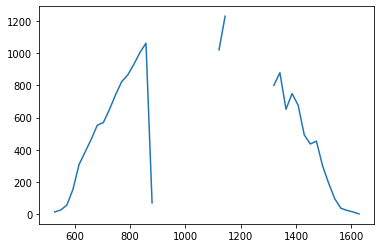

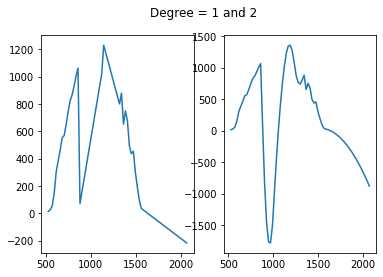

In [ ]:
df2 = gen_data.copy()
df2['DATE'] = pd.to_datetime(gen_data['DATE_TIME']).dt.date.astype(str)
indexes = df2[(df2['Inverter_No']==1)&(df2['DATE']=='2020-05-15')&(df2['AC_POWER']==0)].index
df2.loc[indexes,'AC_POWER']=np.nan
df2 = df2[(df2['Inverter_No']==1)&(df2['DATE']=='2020-05-15')]['AC_POWER']
df2.plot();

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Degree = 1 and 2')
ax1.plot(df2.interpolate(method='spline',order=1))
ax2.plot(df2.interpolate(method='spline',order=2));

In [ ]:
day_only_columns=list()
DC_cols = [i for i in df.columns if 'DC_POWER' in i]
AC_cols = [i for i in df.columns if 'AC_POWER' in i]
day_only_columns = DC_cols+AC_cols+["IRRADIATION"]

def Data_Preparation_Plant_Level(df):
    for col in day_only_columns:
        df[col] = df[col].astype(float)
        # For time except for non-generating hours(12 am to 6 am & 6 pm to 12 am) will be replaced by zero
        df.loc[df[(~((df['BLOCK']>24) & (df['BLOCK']<73))) & df[col].isnull()].index,col] = 0

    # Left NaN value for generating hours(6 am to 6pm) 
       
    df[DC_cols+AC_cols].interpolate(method='polynomial',order = 2,inplace=True)
    df.interpolate(method='linear',inplace=True)
    
    df['AC_POWER'] = df.loc[: ,AC_cols].sum(axis=1)
    df['DC_POWER'] = df.loc[:,DC_cols].sum(axis=1)


    #Scaling generation to MW from kW  
    df['AC_POWER'] = df['AC_POWER']/1000
    df['DC_POWER'] = df['DC_POWER']/1000
    
    return df


df_train = Data_Preparation_Plant_Level(df_train)
df_test = Data_Preparation_Plant_Level(df_test)

<ipython-input-25-6b875acf54f9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
<ipython-input-25-6b875acf54f9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[DC_cols+AC_cols].interpolate(method='polynomial',order = 2,inplace=True)
<ipython-input-25-6b875acf54f9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(method='linear

#Handling Outliers

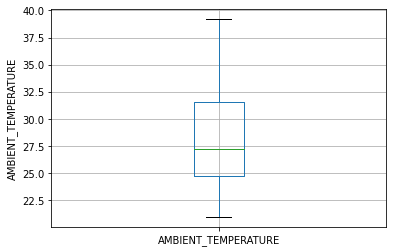

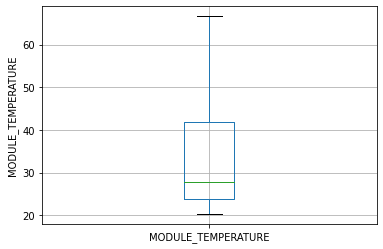

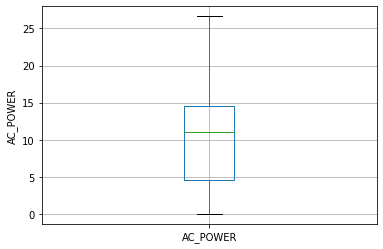

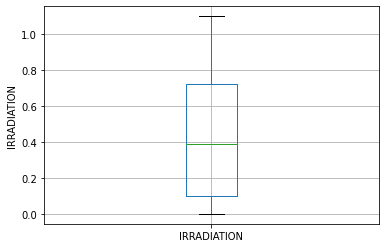

In [ ]:
features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'AC_POWER', 'IRRADIATION']
for feature in features:
    # ignoring zero values for plotting
    df_train[df_train[feature]!=0].boxplot(column=feature)
    plt.ylabel(feature)
    plt.show()

In [ ]:
df_train.drop('DC_POWER',axis=1,inplace=True)
percentile_list = [1,10,25,50,75,85,90,95,99,100]
percentile_dict = {}
for i in df_train.columns[3:]:
    a_list = []
    for j in percentile_list:
        a_list.append(round(np.percentile(df_train[i],j),2))
    percentile_dict[i] = a_list    
pd.DataFrame(pd.concat([pd.DataFrame({'Percentiles':percentile_list}),pd.DataFrame(percentile_dict)],axis=1)) 

<ipython-input-27-3b1f086e7972>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop('DC_POWER',axis=1,inplace=True)


,Percentiles,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER_1,AC_POWER_1,Inverter_No_1,DC_POWER_2,AC_POWER_2,Inverter_No_2,...,DC_POWER_20,AC_POWER_20,Inverter_No_20,DC_POWER_21,AC_POWER_21,Inverter_No_21,DC_POWER_22,AC_POWER_22,Inverter_No_22,AC_POWER
0,1,22.55,21.10,0.00,0.0,0.00,0.00,2.0,0.00,0.00,...,20.0,0.00,0.00,0.0,0.00,0.00,22.0,0.00,0.00,0.00
1,10,23.66,22.40,0.00,1.0,0.00,0.00,2.0,0.00,0.00,...,20.0,0.00,0.00,0.0,0.00,0.00,22.0,0.00,0.00,0.00
2,25,24.73,23.76,0.00,1.0,0.00,0.00,2.0,0.00,0.00,...,20.0,0.00,0.00,0.0,0.00,0.00,22.0,0.00,0.00,0.00
3,50,27.24,27.79,0.02,1.0,0.00,1.21,2.0,0.00,0.00,...,20.0,0.00,0.00,21.0,0.00,170.36,22.0,0.00,0.00,0.47
4,75,31.55,41.75,0.46,1.0,535.66,538.39,2.0,402.93,395.81,...,20.0,482.34,473.00,21.0,312.62,507.60,22.0,426.71,418.87,11.45
5,85,33.54,49.48,0.71,1.0,855.60,844.27,2.0,672.00,658.17,...,20.0,769.56,752.69,21.0,633.78,642.59,22.0,704.60,689.61,14.11
6,90,34.61,52.28,0.80,1.0,1024.51,1003.53,2.0,871.89,853.11,...,20.0,961.87,939.29,21.0,844.76,845.51,22.0,883.88,864.01,15.64
7,95,35.97,55.98,0.90,1.0,1179.63,1150.50,2.0,1085.37,1060.20,...,20.0,1168.48,1139.27,21.0,1102.20,1076.82,22.0,1086.80,1061.28,17.29
8,99,37.40,60.32,0.96,1.0,1313.71,1280.86,2.0,1265.76,1234.17,...,20.0,1289.11,1256.91,21.0,1280.58,1248.68,22.0,1254.15,1223.16,19.99
9,100,39.18,66.64,1.10,1.0,1419.84,1384.35,2.0,1382.21,1347.66,...,20.0,1327.49,1294.30,21.0,1408.86,1373.65,22.0,1406.17,1371.01,26.63


In [ ]:
outlier_imputer_dict = {}
features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'AC_POWER', 'IRRADIATION']
for var in features:
    percentile_dict = {}
    
    NinetyNine_percentile = np.percentile(df_train[var],99)  
       
    First_percentile = np.percentile(df_train[var],1)

    percentile_dict['99th'] =  NinetyNine_percentile
    percentile_dict['1st'] =  First_percentile  
    # Saving as dictionary for each column
    outlier_imputer_dict[var] = percentile_dict
      
#Saving the final dictionary         
np.save('outlier_imputer_dict',outlier_imputer_dict)    
def outlier_imputer(df):
    #Loading Outlier Imputer dictionary
    outlier_dict = np.load('outlier_imputer_dict.npy',allow_pickle='TRUE').item()
    
    for var in features:
        
        df.loc[df[df[var] > outlier_dict[var]['99th']].index,var] = outlier_dict[var]['99th']  
       
        df.loc[df[df[var] < outlier_dict[var]['1st']].index,var] = outlier_dict[var]['1st']
    
    return df

print(outlier_imputer_dict)

#Applying imputation on Train & Test 
df_train = outlier_imputer(df_train)
df_test = outlier_imputer(df_test)

{'AMBIENT_TEMPERATURE': {'99th': 37.39861080172414, '1st': 22.546186481034482}, 'MODULE_TEMPERATURE': {'99th': 60.32299286206897, '1st': 21.099540196666666}, 'AC_POWER': {'99th': 19.993737333333335, '1st': 0.0}, 'IRRADIATION': {'99th': 0.9607427385333338, '1st': 0.0}}


#Building Model

We’ll make a new column named BINS. Each row shall be assigned a bin based on its corresponding 12 Block No.

In [ ]:
cut_blocks = [1,2,3,4,5,6,7,8]
cut_bins =[0, 12, 24, 36, 48, 60, 72, 84, 96]
df_train['BIN'] = pd.cut(df_train['BLOCK'], bins=cut_bins, labels = cut_blocks)
display(df_train)

<ipython-input-29-31849392b6a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['BIN'] = pd.cut(df_train['BLOCK'], bins=cut_bins, labels = cut_blocks)


,BLOCK,DATE,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER_1,AC_POWER_1,Inverter_No_1,DC_POWER_2,...,AC_POWER_20,Inverter_No_20,DC_POWER_21,AC_POWER_21,Inverter_No_21,DC_POWER_22,AC_POWER_22,Inverter_No_22,AC_POWER,BIN
0,1,2020-05-15,00:00,27.004764,25.060789,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,1
1,2,2020-05-15,00:15,26.880811,24.421869,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,1
2,3,2020-05-15,00:30,26.682055,24.427290,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,1
3,4,2020-05-15,00:45,26.500589,24.420678,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,1
4,5,2020-05-15,01:00,26.596148,25.088210,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2966,92,2020-06-14,22:45,24.185657,22.922953,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,8
2967,93,2020-06-14,23:00,24.412542,23.356136,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,8
2968,94,2020-06-14,23:15,24.652915,23.913763,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,8
2969,95,2020-06-14,23:30,24.702391,24.185130,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,21.0,0.0,0.0,22.0,0.0,0.0,0.0,8


In [ ]:
x_train = df_train[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
       'IRRADIATION']]
y_train = df_train[['AC_POWER']]


from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 1000, 10)]
min_samples_split = [2, 5, 10, 14]
min_samples_leaf = [1, 2, 4, 6, 8, 10]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf_randomcv = RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=100,verbose=2,cv=3,random_state=42,n_jobs=-1)
rf_randomcv.fit(x_train, y_train)
print(rf_randomcv.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}


In [ ]:
x_test = df_test[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
y_test = df_test[['AC_POWER']]

best_random = rf_randomcv.best_estimator_

y_pred_rf = best_random.predict(x_test)

print(f'Root Mean Squared Error for Test Data: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}')

Root Mean Squared Error for Test Data: 1.9035090995641928
